## Import modules

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# Prepare Data
#### > Import apple stock data from AAPL.csv file, and separate it into X and y arrays
#### > Rescale data to make it more suitable for the machine learning model
#### > Split data into training and test sets, approximately 80% and 20% of the data respectively


In [25]:
# Load data
data = pd.read_csv('AAPL.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Compute 3 day moving average
data['MA_3'] = data['Close'].rolling(window=3).mean().shift(1)

X = data[['MA_3']].dropna().values
y = data['Close'].iloc[3:].values

#Rescale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#Split data
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define LSTM Model

In [3]:
def create_LSTM_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(1, X_train.shape[2])))
    model.add(LSTM(units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create and Wrap the Model
#### > Define a tensorflow early stopping instance to be used by the model
#### > Create a model using the create_model function, wrapping it inside of a KerasRegressor, provided by the Keras library

In [5]:
#Define early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

#Wrap model
model_keras = KerasRegressor(
    model = create_LSTM_model,
    verbose = 1,
    epochs = 100,
    batch_size = 10,
    callbacks=[early_stopping],
    validation_split = 0.2
)

# Fit Model
#### > Define a parameter that will be used to find the best parameters in GridSearchCV
#### > Define a GridSearchCV model, using our previously-wrapped model as a base. This will be used to find the best combination of paramters
#### > Print the best results of the model

In [6]:
#Define parameter grid
param_grid = {
    'model__units': [30, 50, 100],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [10, 20, 50],
    'epochs': [10, 20, 30]
}

#Define and run model
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score']):
    print("%f (%f) with: %r" % (mean_score, scores, params))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0984e-04 - val_loss: 4.4096e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 2.6494e-07 - val_loss: 4.6234e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.5620e-07 - val_loss: 4.4527e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 2.8351e-07 - val_loss: 5.5600e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 3.4655e-07 - val_loss: 5.2958e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 3.2708e-07 - val_loss: 4.3695e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 3.8762e-07 - val_loss: 5.1310e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 3.3551e-07 - val_loss: 7.9413e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 4.0506e-07 - val_loss: 4.5101e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 3.2742e-07 - val_loss: 5.0371e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1925e-04 - val_loss: 4.4173e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 2.4087e-07 - val_loss: 4.5791e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 2.5348e-07 - val_loss: 7.9815e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 2.6415e-07 - val_loss: 4.6685e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 2.8905e-07 - val_loss: 4.3623e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2.5421e-07 - val_loss: 5.0110e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 3.3299e-07 - val_loss: 4.7357e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 3.6922e-07 - val_loss: 4.9187e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 4.1056e-07 - val_loss: 4.6919e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 3.9076e-07 - val_loss: 1.0856e-05
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.8938e-07 - val_loss: 1.8583e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 6.4454e-07 - val_loss: 2.3039e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 5.6388e-07 - val_loss: 4.2703e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 5.2644e-07 - val_loss: 2.6847e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 5.3866e-07 - val_loss: 2.0150e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 4.8885e-07 - val_loss: 3.3849e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 4.8684e-07 - val_loss: 1.7277e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 4.9014e-07 - val_loss: 2.9683e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 4.6122e-07 - val_loss: 1.5523e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 4.3374e-07 - val_loss: 1.1231e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.7728e-05 - val_loss: 4.6867e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 2.6578e-07 - val_loss: 5.3099e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 3.0450e-07 - val_loss: 4.3637e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 2.9428e-07 - val_loss: 4.4000e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 3.5089e-07 - val_loss: 6.8090e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 4.6278e-07 - val_loss: 4.3732e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 3.8791e-07 - val_loss: 8.9317e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 3.8198e-07 - val_loss: 7.5868e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 4.0418e-07 - val_loss: 4.3551e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 4.4543e-07 - val_loss: 4.9889e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0263e-04 - val_loss: 4.4118e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 2.9474e-07 - val_loss: 8.5659e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 3.4383e-07 - val_loss: 4.5691e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 3.8034e-07 - val_loss: 6.4951e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 4.0141e-07 - val_loss: 5.6598e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 3.3776e-07 - val_loss: 4.4129e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 4.4363e-07 - val_loss: 4.4525e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 4.2313e-07 - val_loss: 5.1220e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 4.0816e-07 - val_loss: 4.4477e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 4.1698e-07 - val_loss: 4.3703e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.8236e-07 - val_loss: 2.5218e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 5.7395e-07 - val_loss: 2.0662e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 5.5239e-07 - val_loss: 3.7857e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 5.0301e-07 - val_loss: 2.3859e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 5.3835e-07 - val_loss: 1.9858e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 5.9619e-07 - val_loss: 2.6876e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 5.7650e-07 - val_loss: 2.9208e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 4.9495e-07 - val_loss: 3.5889e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 5.6746e-07 - val_loss: 2.4253e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 5.5815e-07 - val_loss: 2.1511e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.8219e-05 - val_loss: 4.4330e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 2.9179e-07 - val_loss: 4.4497e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 2.7888e-07 - val_loss: 7.1221e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 4.2790e-07 - val_loss: 4.5869e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 4.8410e-07 - val_loss: 4.3800e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 3.9798e-07 - val_loss: 4.3606e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 3.7339e-07 - val_loss: 4.5815e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 5.4966e-07 - val_loss: 5.6811e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 3.7030e-07 - val_loss: 1.5471e-05
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 4.4889e-07 - val_loss: 4.3576e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.9986e-05 - val_loss: 5.7458e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 2.9803e-07 - val_loss: 5.0498e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 3.6676e-07 - val_loss: 1.0906e-05
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 4.1772e-07 - val_loss: 4.3665e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 4.2961e-07 - val_loss: 5.3501e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 4.3834e-07 - val_loss: 5.2786e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 4.7485e-07 - val_loss: 4.7334e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 3.7431e-07 - val_loss: 4.9647e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 4.7868e-07 - val_loss: 4.5539e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 5.6561e-07 - val_loss: 6.1452e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1669e-06 - val_loss: 2.1521e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 5.9710e-07 - val_loss: 3.6002e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 5.9531e-07 - val_loss: 2.4431e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 5.6365e-07 - val_loss: 4.1247e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 5.4971e-07 - val_loss: 2.8764e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 5.0893e-07 - val_loss: 2.5747e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 5.2744e-07 - val_loss: 2.5415e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 5.3499e-07 - val_loss: 2.5370e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 5.2978e-07 - val_loss: 2.0707e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 5.1633e-07 - val_loss: 2.5566e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.6754e-04 - val_loss: 0.0090
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.7429e-04 - val_loss: 0.0095
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.6647e-04 - val_loss: 0.0082
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 1.6004e-04 - val_loss: 0.0091
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.6718e-04 - val_loss: 0.0094
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 1.6531e-04 - val_loss: 0.0081
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.5818e-04 - val_loss: 0.0083
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 1.5983e-04 - val_loss: 0.0092
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.5349e-04 - val_loss: 0.0092
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 1.6097e-04 - val_loss: 0.0090
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7975e-04 - val_loss: 0.0097
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.7199e-04 - val_loss: 0.0094
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 1.7136e-04 - val_loss: 0.0091
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.7258e-04 - val_loss: 0.0094
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 1.6621e-04 - val_loss: 0.0092
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 1.6621e-04 - val_loss: 0.0096
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 1.6340e-04 - val_loss: 0.0091
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.7385e-04 - val_loss: 0.0092
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.7380e-04 - val_loss: 0.0097
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.5707e-04 - val_loss: 0.0082
Restoring model weights from the end of the best epoch: 10.
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1039e-06 - val_loss: 4.9789e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 9.4394e-07 - val_loss: 5.4513e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 1.0015e-06 - val_loss: 1.6960e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.0126e-06 - val_loss: 6.8636e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 9.9546e-07 - val_loss: 2.6421e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.0044e-06 - val_loss: 2.2625e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.0195e-06 - val_loss: 2.2643e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 9.8237e-07 - val_loss: 2.6427e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 9.7973e-07 - val_loss: 1.9394e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 9.8468e-07 - val_loss: 5.3797e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7741e-04 - val_loss: 0.0099
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.6653e-04 - val_loss: 0.0093
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.6912e-04 - val_loss: 0.0100
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 1.7887e-04 - val_loss: 0.0101
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 1.6292e-04 - val_loss: 0.0093
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 1.6539e-04 - val_loss: 0.0090
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.6462e-04 - val_loss: 0.0090
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 1.6574e-04 - val_loss: 0.0092
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.6859e-04 - val_loss: 0.0093
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.6639e-04 - val_loss: 0.0092
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7325e-04 - val_loss: 0.0088
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.7457e-04 - val_loss: 0.0097
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 1.7830e-04 - val_loss: 0.0103
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.7513e-04 - val_loss: 0.0095
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 1.7032e-04 - val_loss: 0.0085
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.6254e-04 - val_loss: 0.0092
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1.7399e-04 - val_loss: 0.0096
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 1.7258e-04 - val_loss: 0.0089
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 1.5705e-04 - val_loss: 0.0090
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.5844e-04 - val_loss: 0.0085
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2590e-06 - val_loss: 2.0527e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 1.0837e-06 - val_loss: 2.9798e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 1.1504e-06 - val_loss: 1.8530e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 1.1254e-06 - val_loss: 4.6513e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 1.1424e-06 - val_loss: 1.8163e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 1.1827e-06 - val_loss: 1.8626e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 1.1776e-06 - val_loss: 1.7267e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 1.0922e-06 - val_loss: 1.7687e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.1491e-06 - val_loss: 3.9236e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.1352e-06 - val_loss: 2.3160e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7631e-04 - val_loss: 0.0094
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 1.6715e-04 - val_loss: 0.0095
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 1.7130e-04 - val_loss: 0.0090
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 1.5856e-04 - val_loss: 0.0088
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 1.5964e-04 - val_loss: 0.0095
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 1.6698e-04 - val_loss: 0.0099
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 1.5811e-04 - val_loss: 0.0097
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 1.7476e-04 - val_loss: 0.0088
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 1.5793e-04 - val_loss: 0.0090
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1.6118e-04 - val_loss: 0.0083
Restoring model weights from the end of the best epoch: 10.
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.8266e-04 - val_loss: 0.0102
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1.7344e-04 - val_loss: 0.0094
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.8291e-04 - val_loss: 0.0092
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 1.7958e-04 - val_loss: 0.0102
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.7443e-04 - val_loss: 0.0081
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 1.7530e-04 - val_loss: 0.0088
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1.7189e-04 - val_loss: 0.0097
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 1.7295e-04 - val_loss: 0.0082
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 1.7106e-04 - val_loss: 0.0086
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 1.6711e-04 - val_loss: 0.0079
Restoring model weights from the end of the best epoch: 5.
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2614e-06 - val_loss: 1.7313e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 1.1541e-06 - val_loss: 6.7005e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 1.1055e-06 - val_loss: 3.1488e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 1.1199e-06 - val_loss: 1.7458e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 1.1848e-06 - val_loss: 2.2052e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.1646e-06 - val_loss: 1.6831e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 1.1203e-06 - val_loss: 3.3288e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 1.1064e-06 - val_loss: 2.0559e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 1.1879e-06 - val_loss: 4.3144e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.1170e-06 - val_loss: 5.1753e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0295e-04 - val_loss: 4.4391e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 2.3437e-07 - val_loss: 4.4890e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2.9839e-07 - val_loss: 4.7344e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 2.7709e-07 - val_loss: 9.2734e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 3.4811e-07 - val_loss: 5.7547e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 4.4824e-07 - val_loss: 4.3778e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 4.2811e-07 - val_loss: 1.0612e-05
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 4.1324e-07 - val_loss: 4.9592e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 3.6783e-07 - val_loss: 4.4270e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 3.1838e-07 - val_loss: 6.2048e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1389e-04 - val_loss: 4.3604e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 2.8517e-07 - val_loss: 5.4949e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 2.7724e-07 - val_loss: 4.4094e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 2.6464e-07 - val_loss: 4.7012e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 3.0013e-07 - val_loss: 5.0983e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 4.3325e-07 - val_loss: 4.9568e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 3.9233e-07 - val_loss: 4.7081e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 3.8934e-07 - val_loss: 5.3237e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 2.9976e-07 - val_loss: 4.7592e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 3.1696e-07 - val_loss: 5.8165e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.8647e-07 - val_loss: 4.6497e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 7.6965e-07 - val_loss: 2.7647e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 5.7820e-07 - val_loss: 2.7954e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 5.2918e-07 - val_loss: 3.5932e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 5.5351e-07 - val_loss: 2.2108e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 5.3511e-07 - val_loss: 2.7631e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 5.2101e-07 - val_loss: 2.9580e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 5.1583e-07 - val_loss: 3.2425e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 4.9689e-07 - val_loss: 3.0415e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 5.2686e-07 - val_loss: 3.8827e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1244e-04 - val_loss: 4.4139e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 2.7495e-07 - val_loss: 4.6204e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 3.1922e-07 - val_loss: 4.4850e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 3.8737e-07 - val_loss: 5.1044e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 4.0623e-07 - val_loss: 4.4524e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 3.7383e-07 - val_loss: 4.3533e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 3.5625e-07 - val_loss: 4.5343e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 3.9445e-07 - val_loss: 4.8247e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 3.3615e-07 - val_loss: 1.0132e-05
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 3.2758e-07 - val_loss: 4.6818e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0835e-04 - val_loss: 4.6633e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 2.3841e-07 - val_loss: 4.4741e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 2.9988e-07 - val_loss: 4.4327e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 3.4990e-07 - val_loss: 4.4808e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 3.2400e-07 - val_loss: 4.5525e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 4.0167e-07 - val_loss: 5.0408e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 3.7202e-07 - val_loss: 4.6742e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 3.5311e-07 - val_loss: 4.6045e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 3.6173e-07 - val_loss: 5.5386e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 3.1498e-07 - val_loss: 4.9856e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.8014e-07 - val_loss: 2.1583e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 5.9687e-07 - val_loss: 1.9258e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 5.7338e-07 - val_loss: 4.1025e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 5.8523e-07 - val_loss: 2.5618e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 5.2340e-07 - val_loss: 2.0449e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 5.3563e-07 - val_loss: 2.3453e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 5.3586e-07 - val_loss: 1.6868e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 6.1853e-07 - val_loss: 1.8881e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 5.5927e-07 - val_loss: 2.2283e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 5.2653e-07 - val_loss: 3.0442e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.5282e-05 - val_loss: 4.4393e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 2.6535e-07 - val_loss: 4.6930e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 3.6052e-07 - val_loss: 4.3705e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 3.7855e-07 - val_loss: 5.6341e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 3.6494e-07 - val_loss: 1.2854e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 4.6596e-07 - val_loss: 6.1674e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 3.8267e-07 - val_loss: 7.6887e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 7.0133e-07 - val_loss: 6.7262e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 5.0657e-07 - val_loss: 4.6669e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 4.1136e-07 - val_loss: 8.6065e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0547e-04 - val_loss: 4.6394e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 3.0262e-07 - val_loss: 4.8096e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 3.2202e-07 - val_loss: 5.6874e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 3.5593e-07 - val_loss: 5.1780e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 4.3507e-07 - val_loss: 1.0842e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 5.0693e-07 - val_loss: 8.6313e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 4.1526e-07 - val_loss: 7.9521e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 4.2605e-07 - val_loss: 4.7171e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 3.6114e-07 - val_loss: 4.5946e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 5.7566e-07 - val_loss: 4.6573e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0218e-06 - val_loss: 1.8077e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 7.0884e-07 - val_loss: 3.4768e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 5.9632e-07 - val_loss: 2.9324e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 5.4812e-07 - val_loss: 3.8793e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 5.2021e-07 - val_loss: 3.0184e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 5.6291e-07 - val_loss: 3.4723e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 5.4846e-07 - val_loss: 2.4703e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 5.2687e-07 - val_loss: 3.6978e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 5.2787e-07 - val_loss: 4.8563e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 6.0047e-07 - val_loss: 2.7603e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.6553e-04 - val_loss: 0.0095
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.7199e-04 - val_loss: 0.0087
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.6979e-04 - val_loss: 0.0090
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 1.7109e-04 - val_loss: 0.0096
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.6253e-04 - val_loss: 0.0095
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.6569e-04 - val_loss: 0.0095
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.6248e-04 - val_loss: 0.0089
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.5486e-04 - val_loss: 0.0084
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.5672e-04 - val_loss: 0.0090
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.4585e-04 - val_loss: 0.0087
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 1.5355e-04 - val_loss: 0.0081

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.8570e-04 - val_loss: 0.0096
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.7181e-04 - val_loss: 0.0099
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 1.7330e-04 - val_loss: 0.0085
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.7109e-04 - val_loss: 0.0097
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 1.7053e-04 - val_loss: 0.0101
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1.7775e-04 - val_loss: 0.0092
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.7266e-04 - val_loss: 0.0090
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.7286e-04 - val_loss: 0.0098
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.6339e-04 - val_loss: 0.0090
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1.6857e-04 - val_loss: 0.0084
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.6351e-04 - val_loss: 0.0091

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3090e-06 - val_loss: 1.9861e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.2803e-06 - val_loss: 1.6520e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 1.2419e-06 - val_loss: 6.0689e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 1.2791e-06 - val_loss: 1.6480e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 1.2617e-06 - val_loss: 1.7665e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1.2742e-06 - val_loss: 1.9810e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.2641e-06 - val_loss: 3.1625e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.2641e-06 - val_loss: 1.6841e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.2898e-06 - val_loss: 1.6697e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 1.3112e-06 - val_loss: 8.0328e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.6739e-04 - val_loss: 0.0103
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 1.7397e-04 - val_loss: 0.0096
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 1.5892e-04 - val_loss: 0.0097
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.7726e-04 - val_loss: 0.0103
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.7003e-04 - val_loss: 0.0095
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 1.7355e-04 - val_loss: 0.0085
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 1.7412e-04 - val_loss: 0.0099
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.5576e-04 - val_loss: 0.0096
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.5976e-04 - val_loss: 0.0097
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.6468e-04 - val_loss: 0.0094
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 1.5282e-04 - val_loss: 0.0074

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.8181e-04 - val_loss: 0.0090
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 1.8283e-04 - val_loss: 0.0103
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 1.7457e-04 - val_loss: 0.0094
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.6329e-04 - val_loss: 0.0099
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 1.6355e-04 - val_loss: 0.0097
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 1.6416e-04 - val_loss: 0.0092
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.6673e-04 - val_loss: 0.0094
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 1.5709e-04 - val_loss: 0.0097
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.6611e-04 - val_loss: 0.0097
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.6901e-04 - val_loss: 0.0085
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 1.6221e-04 - val_loss: 0.0085

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3774e-06 - val_loss: 4.4677e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 1.1643e-06 - val_loss: 8.5987e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 1.2003e-06 - val_loss: 1.6780e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 1.2829e-06 - val_loss: 1.8134e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 1.1956e-06 - val_loss: 3.2800e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 1.2033e-06 - val_loss: 4.8839e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 1.1992e-06 - val_loss: 3.5306e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 1.1563e-06 - val_loss: 4.2578e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 1.1748e-06 - val_loss: 5.6729e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 1.3161e-06 - val_loss: 1.9624e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7671e-04 - val_loss: 0.0087
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.7357e-04 - val_loss: 0.0106
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 1.6103e-04 - val_loss: 0.0092
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.6335e-04 - val_loss: 0.0101
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6953e-04 - val_loss: 0.0098
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6966e-04 - val_loss: 0.0095
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.5744e-04 - val_loss: 0.0099
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.6114e-04 - val_loss: 0.0097
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 1.5469e-04 - val_loss: 0.0095
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 1.6351e-04 - val_loss: 0.0094
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.6187e-04 - val_loss: 0.0099

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7583e-04 - val_loss: 0.0099
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.7826e-04 - val_loss: 0.0089
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 1.8028e-04 - val_loss: 0.0097
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.7319e-04 - val_loss: 0.0080
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 1.7981e-04 - val_loss: 0.0096
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 1.7160e-04 - val_loss: 0.0099
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.6156e-04 - val_loss: 0.0092
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 1.7018e-04 - val_loss: 0.0074
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.7098e-04 - val_loss: 0.0082
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 1.6376e-04 - val_loss: 0.0087
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.6053e-04 - val_loss: 0.0086

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3869e-06 - val_loss: 2.5416e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.1759e-06 - val_loss: 4.4671e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1.1750e-06 - val_loss: 1.6672e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.2404e-06 - val_loss: 5.8489e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.2433e-06 - val_loss: 4.4007e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.2098e-06 - val_loss: 2.0354e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.2272e-06 - val_loss: 3.8074e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.1496e-06 - val_loss: 9.6458e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.2526e-06 - val_loss: 2.0521e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.1631e-06 - val_loss: 1.7800e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1426e-04 - val_loss: 4.6538e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 2.3960e-07 - val_loss: 4.3896e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 2.2203e-07 - val_loss: 5.6995e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 2.8768e-07 - val_loss: 5.0914e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 3.2079e-07 - val_loss: 4.7473e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 3.4917e-07 - val_loss: 5.2779e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 4.8337e-07 - val_loss: 1.3232e-05
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 3.8235e-07 - val_loss: 6.8259e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 3.6244e-07 - val_loss: 5.5495e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 3.6771e-07 - val_loss: 4.6314e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2021e-04 - val_loss: 4.7657e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 2.1533e-07 - val_loss: 5.3592e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2.5854e-07 - val_loss: 4.3810e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 2.8572e-07 - val_loss: 4.4365e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 3.8915e-07 - val_loss: 9.5293e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 3.8572e-07 - val_loss: 4.4088e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 3.0299e-07 - val_loss: 4.4231e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 3.4782e-07 - val_loss: 5.2903e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 3.8817e-07 - val_loss: 4.7911e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 3.5079e-07 - val_loss: 5.5919e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.9056e-07 - val_loss: 3.5847e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 5.6857e-07 - val_loss: 3.8526e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 6.3107e-07 - val_loss: 2.7652e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 5.6412e-07 - val_loss: 2.9254e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 5.5179e-07 - val_loss: 1.9882e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 5.4871e-07 - val_loss: 2.1998e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 5.4888e-07 - val_loss: 1.6917e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 5.7013e-07 - val_loss: 2.8195e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 5.3402e-07 - val_loss: 3.1136e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 5.5527e-07 - val_loss: 2.6334e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0276e-04 - val_loss: 4.4100e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 2.6737e-07 - val_loss: 5.2225e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 2.8714e-07 - val_loss: 4.7126e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 2.9368e-07 - val_loss: 7.3277e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 3.5676e-07 - val_loss: 6.1652e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 3.7497e-07 - val_loss: 5.5542e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 3.6810e-07 - val_loss: 4.5794e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 5.5214e-07 - val_loss: 4.5097e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 3.9160e-07 - val_loss: 4.8062e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 4.7572e-07 - val_loss: 7.0191e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.4564e-05 - val_loss: 4.3594e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.5362e-07 - val_loss: 8.6479e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 3.3591e-07 - val_loss: 6.2789e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2.8467e-07 - val_loss: 5.0582e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 3.9989e-07 - val_loss: 5.6194e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 3.2216e-07 - val_loss: 5.1696e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 4.1163e-07 - val_loss: 4.9866e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 4.4617e-07 - val_loss: 4.7840e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 5.0612e-07 - val_loss: 4.4081e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 3.7439e-07 - val_loss: 4.6894e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.4528e-07 - val_loss: 3.4568e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 5.5927e-07 - val_loss: 3.5171e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 5.8724e-07 - val_loss: 2.7904e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 5.4578e-07 - val_loss: 3.0931e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 5.4080e-07 - val_loss: 2.3420e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 5.2993e-07 - val_loss: 1.8644e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 5.6209e-07 - val_loss: 2.3218e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 5.7596e-07 - val_loss: 2.4362e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 5.1329e-07 - val_loss: 3.2352e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 5.2041e-07 - val_loss: 3.0420e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.2929e-05 - val_loss: 4.6898e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 2.9997e-07 - val_loss: 4.9229e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 3.3717e-07 - val_loss: 5.0996e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 3.4974e-07 - val_loss: 4.3726e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 4.5775e-07 - val_loss: 5.3811e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 4.0468e-07 - val_loss: 7.1340e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 3.6336e-07 - val_loss: 8.1834e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 4.9522e-07 - val_loss: 4.4643e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 4.7183e-07 - val_loss: 4.4586e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 4.5581e-07 - val_loss: 4.8673e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0424e-04 - val_loss: 5.2118e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 2.7114e-07 - val_loss: 4.9650e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 4.4551e-07 - val_loss: 4.7245e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 4.2922e-07 - val_loss: 5.0150e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 3.8316e-07 - val_loss: 1.0547e-05
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 4.1387e-07 - val_loss: 4.4898e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 5.1177e-07 - val_loss: 5.3037e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 3.9004e-07 - val_loss: 4.6933e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 3.5130e-07 - val_loss: 4.5149e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 4.0216e-07 - val_loss: 1.1501e-05
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.7805e-07 - val_loss: 5.3884e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 6.2381e-07 - val_loss: 2.6138e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 5.5903e-07 - val_loss: 2.7520e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 5.9701e-07 - val_loss: 2.1198e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 5.2921e-07 - val_loss: 3.2599e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 5.2321e-07 - val_loss: 2.4521e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 5.4697e-07 - val_loss: 3.2886e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 5.2947e-07 - val_loss: 2.3753e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 5.5980e-07 - val_loss: 2.6489e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 5.5863e-07 - val_loss: 2.1531e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.6752e-04 - val_loss: 0.0099
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.6494e-04 - val_loss: 0.0094
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 1.6240e-04 - val_loss: 0.0086
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 1.5601e-04 - val_loss: 0.0083
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.5968e-04 - val_loss: 0.0090
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 1.5769e-04 - val_loss: 0.0079
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 1.5451e-04 - val_loss: 0.0083
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 1.4792e-04 - val_loss: 0.0087
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.4663e-04 - val_loss: 0.0083
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 1.4513e-04 - val_loss: 0.0090
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.3665e-04 - val_loss: 0.0084

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7718e-04 - val_loss: 0.0086
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.7904e-04 - val_loss: 0.0099
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 1.7240e-04 - val_loss: 0.0102
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.7320e-04 - val_loss: 0.0086
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 1.8000e-04 - val_loss: 0.0095
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.6514e-04 - val_loss: 0.0086
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 1.6931e-04 - val_loss: 0.0087
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 1.6134e-04 - val_loss: 0.0096
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.6552e-04 - val_loss: 0.0094
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.6329e-04 - val_loss: 0.0093
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.5378e-04 - val_loss: 0.0080

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1324e-06 - val_loss: 3.8832e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.0764e-06 - val_loss: 5.7480e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 1.0234e-06 - val_loss: 6.0112e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.0199e-06 - val_loss: 3.2988e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.0976e-06 - val_loss: 1.6316e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.1192e-06 - val_loss: 3.7838e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 1.0340e-06 - val_loss: 3.7806e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.0284e-06 - val_loss: 2.3847e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 9.8906e-07 - val_loss: 2.2463e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.0201e-06 - val_loss: 6.6650e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.5858e-04 - val_loss: 0.0092
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 1.7359e-04 - val_loss: 0.0085
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 1.6561e-04 - val_loss: 0.0094
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.6765e-04 - val_loss: 0.0085
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 1.7070e-04 - val_loss: 0.0089
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 1.6756e-04 - val_loss: 0.0094
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 1.6002e-04 - val_loss: 0.0087
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1.6371e-04 - val_loss: 0.0095
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 1.5477e-04 - val_loss: 0.0094
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.6512e-04 - val_loss: 0.0092
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 1.5093e-04 - val_loss: 0.0078

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7888e-04 - val_loss: 0.0107
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 1.7571e-04 - val_loss: 0.0103
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.7438e-04 - val_loss: 0.0095
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.7505e-04 - val_loss: 0.0094
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.7535e-04 - val_loss: 0.0096
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.7512e-04 - val_loss: 0.0089
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.7603e-04 - val_loss: 0.0084
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 1.6935e-04 - val_loss: 0.0093
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 1.6897e-04 - val_loss: 0.0087
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.5780e-04 - val_loss: 0.0082
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1.6880e-04 - val_loss: 0.0091

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3294e-06 - val_loss: 7.8477e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 1.2945e-06 - val_loss: 9.0008e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.1948e-06 - val_loss: 1.6738e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.1459e-06 - val_loss: 2.2807e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.2118e-06 - val_loss: 1.9627e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.2404e-06 - val_loss: 2.9530e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.1585e-06 - val_loss: 1.6623e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.1487e-06 - val_loss: 4.6574e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.1815e-06 - val_loss: 2.0907e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 1.1613e-06 - val_loss: 1.6949e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.8454e-04 - val_loss: 0.0103
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 1.7302e-04 - val_loss: 0.0079
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1.7944e-04 - val_loss: 0.0096
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 1.5738e-04 - val_loss: 0.0094
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 1.6629e-04 - val_loss: 0.0094
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 1.6368e-04 - val_loss: 0.0092
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 1.6933e-04 - val_loss: 0.0083
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 1.6158e-04 - val_loss: 0.0076
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 1.5543e-04 - val_loss: 0.0081
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 1.5594e-04 - val_loss: 0.0081
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 1.5846e-04 - val_loss: 0.0094

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7780e-04 - val_loss: 0.0089
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 1.6739e-04 - val_loss: 0.0099
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 1.7261e-04 - val_loss: 0.0091
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 1.6184e-04 - val_loss: 0.0102
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 1.6562e-04 - val_loss: 0.0100
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 1.6108e-04 - val_loss: 0.0100
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 1.6588e-04 - val_loss: 0.0088
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1.6073e-04 - val_loss: 0.0090
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 1.6344e-04 - val_loss: 0.0089
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 1.5886e-04 - val_loss: 0.0096
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 1.7013e-04 - val_loss: 0.0081

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0948e-06 - val_loss: 3.5099e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 9.9575e-07 - val_loss: 1.9354e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.0413e-06 - val_loss: 3.2607e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 1.0370e-06 - val_loss: 2.8238e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 1.0367e-06 - val_loss: 1.9835e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 1.0418e-06 - val_loss: 6.6156e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.0188e-06 - val_loss: 1.7941e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 9.9109e-07 - val_loss: 1.7877e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 9.9504e-07 - val_loss: 6.6493e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 1.0491e-06 - val_loss: 1.9734e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5287e-04 - val_loss: 2.1446e-05
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 3.6793e-07 - val_loss: 4.9077e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1.8126e-07 - val_loss: 5.4159e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 2.6692e-07 - val_loss: 4.9933e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2.6958e-07 - val_loss: 5.3387e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 2.4954e-07 - val_loss: 4.4171e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 2.9469e-07 - val_loss: 4.3907e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 2.9505e-07 - val_loss: 4.9439e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2.5507e-07 - val_loss: 4.3937e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 3.4381e-07 - val_loss: 6.4167e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4502e-04 - val_loss: 4.4801e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 2.0756e-07 - val_loss: 4.4222e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 2.4651e-07 - val_loss: 4.5262e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2.0629e-07 - val_loss: 4.3773e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 2.9720e-07 - val_loss: 4.6141e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 2.7442e-07 - val_loss: 4.4022e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 2.7779e-07 - val_loss: 4.7746e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 2.9354e-07 - val_loss: 4.4970e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 2.9100e-07 - val_loss: 5.5701e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 2.9399e-07 - val_loss: 5.2741e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.8035e-07 - val_loss: 3.7935e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 5.5846e-07 - val_loss: 2.5631e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 5.5163e-07 - val_loss: 2.4166e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 5.5892e-07 - val_loss: 2.9853e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 5.2008e-07 - val_loss: 3.4181e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 5.1245e-07 - val_loss: 3.0035e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 5.1556e-07 - val_loss: 2.2252e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 5.7179e-07 - val_loss: 2.0007e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 4.5734e-07 - val_loss: 2.1281e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 4.8048e-07 - val_loss: 2.3772e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4695e-04 - val_loss: 6.5232e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 2.1675e-07 - val_loss: 4.5420e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 2.4606e-07 - val_loss: 4.5590e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 2.8586e-07 - val_loss: 4.3702e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 3.0452e-07 - val_loss: 6.5877e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 3.2019e-07 - val_loss: 4.7661e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 2.8773e-07 - val_loss: 4.4657e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 3.0936e-07 - val_loss: 4.8036e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 2.8706e-07 - val_loss: 4.3642e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 2.8671e-07 - val_loss: 4.5602e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2964e-04 - val_loss: 4.6870e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 1.9822e-07 - val_loss: 4.4468e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 2.2232e-07 - val_loss: 4.5917e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 2.4866e-07 - val_loss: 4.6654e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 3.1309e-07 - val_loss: 4.5886e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 3.9288e-07 - val_loss: 4.6410e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 2.4075e-07 - val_loss: 4.6073e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 3.9172e-07 - val_loss: 4.4510e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 3.8561e-07 - val_loss: 5.0269e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 3.0497e-07 - val_loss: 4.4074e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.4954e-07 - val_loss: 2.7488e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 5.5285e-07 - val_loss: 3.4796e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 5.4087e-07 - val_loss: 3.7859e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 5.9058e-07 - val_loss: 3.2912e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 5.4841e-07 - val_loss: 2.5784e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 5.2760e-07 - val_loss: 1.8438e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 5.3186e-07 - val_loss: 2.1455e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 5.5454e-07 - val_loss: 2.7086e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 4.8022e-07 - val_loss: 2.1790e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 4.8646e-07 - val_loss: 4.0430e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1547e-04 - val_loss: 4.7408e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 2.3178e-07 - val_loss: 5.5140e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 2.3218e-07 - val_loss: 5.1688e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 2.5516e-07 - val_loss: 4.3686e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 2.6596e-07 - val_loss: 4.3736e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 2.9820e-07 - val_loss: 4.5693e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 4.3736e-07 - val_loss: 4.3896e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 3.5451e-07 - val_loss: 5.2496e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 3.2298e-07 - val_loss: 4.6827e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 3.5814e-07 - val_loss: 4.3984e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4246e-04 - val_loss: 4.4099e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 2.3504e-07 - val_loss: 4.5567e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 2.3463e-07 - val_loss: 4.3565e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 2.5841e-07 - val_loss: 6.7476e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 4.0726e-07 - val_loss: 4.5698e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 2.6863e-07 - val_loss: 4.7971e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 3.6446e-07 - val_loss: 4.4906e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 3.6746e-07 - val_loss: 4.6007e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 3.4400e-07 - val_loss: 4.6529e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 3.4624e-07 - val_loss: 4.4914e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1090e-06 - val_loss: 2.5006e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 5.5315e-07 - val_loss: 2.9138e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 5.2725e-07 - val_loss: 2.1811e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 5.7030e-07 - val_loss: 3.0154e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 5.3058e-07 - val_loss: 3.1899e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 5.3285e-07 - val_loss: 2.8029e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 5.2009e-07 - val_loss: 2.2430e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 4.9322e-07 - val_loss: 3.6160e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 5.1139e-07 - val_loss: 3.2256e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 4.9221e-07 - val_loss: 2.5520e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8263e-04 - val_loss: 0.0098
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.6771e-04 - val_loss: 0.0090
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 1.7119e-04 - val_loss: 0.0089
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 1.6809e-04 - val_loss: 0.0096
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 1.6833e-04 - val_loss: 0.0090
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 1.7066e-04 - val_loss: 0.0093
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 1.7067e-04 - val_loss: 0.0086
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 1.7905e-04 - val_loss: 0.0096
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 1.7059e-04 - val_loss: 0.0090
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 1.6398e-04 - val_loss: 0.0098
Restoring model weights from the end of the best epoch: 7.
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7888e-04 - val_loss: 0.0096
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.6941e-04 - val_loss: 0.0083
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.7206e-04 - val_loss: 0.0090
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.5699e-04 - val_loss: 0.0091
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.7426e-04 - val_loss: 0.0090
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.7268e-04 - val_loss: 0.0101
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.7248e-04 - val_loss: 0.0084
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.6475e-04 - val_loss: 0.0100
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6997e-04 - val_loss: 0.0098
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.6824e-04 - val_loss: 0.0096
Restoring model weights from the end of the best epoch: 2.
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3492e-06 - val_loss: 2.2831e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.1066e-06 - val_loss: 3.9939e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.0404e-06 - val_loss: 2.2514e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.0528e-06 - val_loss: 2.0014e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.1352e-06 - val_loss: 1.6886e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.0977e-06 - val_loss: 2.3660e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.0700e-06 - val_loss: 6.0720e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.0595e-06 - val_loss: 3.9592e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.1355e-06 - val_loss: 1.6971e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.1415e-06 - val_loss: 5.3786e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7783e-04 - val_loss: 0.0094
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.5504e-04 - val_loss: 0.0100
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.6876e-04 - val_loss: 0.0086
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.5950e-04 - val_loss: 0.0099
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.6895e-04 - val_loss: 0.0083
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 1.6396e-04 - val_loss: 0.0105
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.6407e-04 - val_loss: 0.0083
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 1.6171e-04 - val_loss: 0.0078
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.5563e-04 - val_loss: 0.0098
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.6615e-04 - val_loss: 0.0101
Restoring model weights from the end of the best epoch: 5.
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7579e-04 - val_loss: 0.0083
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.7558e-04 - val_loss: 0.0092
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.6847e-04 - val_loss: 0.0085
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.7986e-04 - val_loss: 0.0093
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 1.6193e-04 - val_loss: 0.0097
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 1.8486e-04 - val_loss: 0.0082
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.7361e-04 - val_loss: 0.0099
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 1.7236e-04 - val_loss: 0.0102
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 1.6985e-04 - val_loss: 0.0099
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.7293e-04 - val_loss: 0.0086
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4844e-06 - val_loss: 5.2526e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.2723e-06 - val_loss: 4.6962e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.3148e-06 - val_loss: 1.6317e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.1559e-06 - val_loss: 3.0198e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 1.2399e-06 - val_loss: 4.9859e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.1950e-06 - val_loss: 3.8516e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.1499e-06 - val_loss: 4.4533e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.2356e-06 - val_loss: 8.4700e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.3510e-06 - val_loss: 1.7571e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.2789e-06 - val_loss: 1.8143e-06
Restoring model weights from the end of t

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7143e-04 - val_loss: 0.0090
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.6031e-04 - val_loss: 0.0106
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 1.6088e-04 - val_loss: 0.0099
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.6686e-04 - val_loss: 0.0088
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.6971e-04 - val_loss: 0.0098
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 1.6914e-04 - val_loss: 0.0091
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 1.6407e-04 - val_loss: 0.0102
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 1.6364e-04 - val_loss: 0.0098
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 1.6426e-04 - val_loss: 0.0095
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.6599e-04 - val_loss: 0.0103
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7681e-04 - val_loss: 0.0086
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.7002e-04 - val_loss: 0.0086
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.6414e-04 - val_loss: 0.0090
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 1.7460e-04 - val_loss: 0.0105
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 1.7030e-04 - val_loss: 0.0087
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 1.7238e-04 - val_loss: 0.0104
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 1.7097e-04 - val_loss: 0.0090
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 1.5582e-04 - val_loss: 0.0097
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 1.7070e-04 - val_loss: 0.0088
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 1.6044e-04 - val_loss: 0.0078
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3235e-06 - val_loss: 1.7517e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 1.1553e-06 - val_loss: 4.2644e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 1.0565e-06 - val_loss: 2.1728e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 1.0199e-06 - val_loss: 2.5278e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 1.1473e-06 - val_loss: 4.0424e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 1.0795e-06 - val_loss: 1.8068e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 1.1836e-06 - val_loss: 2.6608e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 1.2259e-06 - val_loss: 3.4004e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 9.8284e-07 - val_loss: 1.7910e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.1305e-06 - val_loss: 1.6591e-06
Restoring model weights from the end of the best epo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4255e-04 - val_loss: 8.6542e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 2.3869e-07 - val_loss: 4.4545e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 2.1116e-07 - val_loss: 4.4129e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 2.4877e-07 - val_loss: 4.4467e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2.4651e-07 - val_loss: 4.6140e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 2.7319e-07 - val_loss: 4.5290e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 2.5910e-07 - val_loss: 4.4033e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 3.0170e-07 - val_loss: 4.4387e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 2.9980e-07 - val_loss: 4.5445e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 3.0562e-07 - val_loss: 5.3663e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3413e-04 - val_loss: 4.4340e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2.2038e-07 - val_loss: 5.0391e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2.3617e-07 - val_loss: 4.5245e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 2.2318e-07 - val_loss: 4.3878e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 2.4424e-07 - val_loss: 5.9738e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 3.4332e-07 - val_loss: 4.4045e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 2.6322e-07 - val_loss: 4.3846e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 2.9704e-07 - val_loss: 5.4155e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2.2994e-07 - val_loss: 5.2855e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2.7217e-07 - val_loss: 4.6635e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4129e-07 - val_loss: 1.6970e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 5.5177e-07 - val_loss: 2.0199e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 5.6202e-07 - val_loss: 5.2533e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 6.0945e-07 - val_loss: 2.6094e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 5.1050e-07 - val_loss: 2.2972e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 5.0316e-07 - val_loss: 4.2935e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 5.0876e-07 - val_loss: 2.6168e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 4.6140e-07 - val_loss: 2.6885e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 4.6661e-07 - val_loss: 1.8124e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 4.7377e-07 - val_loss: 2.1455e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3937e-04 - val_loss: 7.4194e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 2.3876e-07 - val_loss: 4.4349e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 2.2794e-07 - val_loss: 4.7170e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 2.7280e-07 - val_loss: 4.7549e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 2.6907e-07 - val_loss: 4.3699e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 2.6591e-07 - val_loss: 5.0024e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 2.9709e-07 - val_loss: 5.1640e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 2.8428e-07 - val_loss: 4.5747e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 3.0275e-07 - val_loss: 4.5425e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 3.2248e-07 - val_loss: 4.8691e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4583e-04 - val_loss: 5.6577e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 1.9874e-07 - val_loss: 4.3632e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 2.3439e-07 - val_loss: 4.3516e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 2.7102e-07 - val_loss: 4.5235e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 2.7543e-07 - val_loss: 4.6336e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 2.5285e-07 - val_loss: 4.7018e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2.6589e-07 - val_loss: 4.4862e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 3.4161e-07 - val_loss: 4.6377e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 3.1122e-07 - val_loss: 4.4956e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.5245e-07 - val_loss: 4.3563e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.0931e-07 - val_loss: 2.9980e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 5.8278e-07 - val_loss: 4.4091e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 5.7415e-07 - val_loss: 2.0819e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 5.5457e-07 - val_loss: 3.2123e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 5.2909e-07 - val_loss: 4.3011e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 5.4776e-07 - val_loss: 1.9954e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 5.2371e-07 - val_loss: 2.6807e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 4.8250e-07 - val_loss: 3.5495e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 6.1724e-07 - val_loss: 2.3281e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 4.7396e-07 - val_loss: 2.5269e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1982e-04 - val_loss: 4.5123e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 2.8121e-07 - val_loss: 4.8735e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 3.8128e-07 - val_loss: 5.1143e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 3.3158e-07 - val_loss: 4.3884e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 3.1823e-07 - val_loss: 4.6032e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 2.8282e-07 - val_loss: 4.8287e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 5.3430e-07 - val_loss: 4.6627e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 4.3727e-07 - val_loss: 4.4132e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 3.1935e-07 - val_loss: 4.5488e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 3.1668e-07 - val_loss: 4.6271e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4606e-04 - val_loss: 7.1697e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 3.3151e-07 - val_loss: 4.9389e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 2.3824e-07 - val_loss: 4.3760e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 2.6977e-07 - val_loss: 5.8376e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 3.2714e-07 - val_loss: 5.1711e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 3.6776e-07 - val_loss: 5.0642e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 3.9279e-07 - val_loss: 4.8896e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 3.1144e-07 - val_loss: 4.5593e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 3.8628e-07 - val_loss: 4.3651e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 3.1442e-07 - val_loss: 4.3759e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1242e-06 - val_loss: 2.2347e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 5.5617e-07 - val_loss: 2.0543e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 5.3820e-07 - val_loss: 2.6349e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 5.7689e-07 - val_loss: 5.8435e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 6.2501e-07 - val_loss: 2.8210e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 5.1152e-07 - val_loss: 2.3873e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 5.8653e-07 - val_loss: 2.1666e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 5.3835e-07 - val_loss: 3.1342e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 5.0524e-07 - val_loss: 3.3689e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 5.1285e-07 - val_loss: 3.2873e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.7232e-04 - val_loss: 0.0095
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.6955e-04 - val_loss: 0.0086
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 1.6319e-04 - val_loss: 0.0101
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 1.6073e-04 - val_loss: 0.0094
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 1.6217e-04 - val_loss: 0.0102
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.5989e-04 - val_loss: 0.0083
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.6519e-04 - val_loss: 0.0088
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.6661e-04 - val_loss: 0.0080
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.7109e-04 - val_loss: 0.0093
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.5609e-04 - val_loss: 0.0091
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.5489e-04 - val_loss: 0.0095

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7513e-04 - val_loss: 0.0102
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.7688e-04 - val_loss: 0.0094
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.6322e-04 - val_loss: 0.0096
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6412e-04 - val_loss: 0.0081
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.5957e-04 - val_loss: 0.0101
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.7368e-04 - val_loss: 0.0083
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.7546e-04 - val_loss: 0.0095
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6428e-04 - val_loss: 0.0083
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.6781e-04 - val_loss: 0.0091
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.7415e-04 - val_loss: 0.0098
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.7155e-04 - val_loss: 0.0095

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1478e-06 - val_loss: 1.1568e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.0484e-06 - val_loss: 6.1153e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 9.4157e-07 - val_loss: 2.4421e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.0267e-06 - val_loss: 3.1164e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 9.9876e-07 - val_loss: 2.2151e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.0035e-06 - val_loss: 1.8520e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 9.3138e-07 - val_loss: 7.2679e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 1.0893e-06 - val_loss: 3.5592e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 9.9089e-07 - val_loss: 1.9182e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 9.6824e-07 - val_loss: 6.3449e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7456e-04 - val_loss: 0.0089
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.7452e-04 - val_loss: 0.0088
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.6772e-04 - val_loss: 0.0100
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 1.5922e-04 - val_loss: 0.0101
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.6591e-04 - val_loss: 0.0091
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.6717e-04 - val_loss: 0.0101
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.6447e-04 - val_loss: 0.0087
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.7357e-04 - val_loss: 0.0094
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6794e-04 - val_loss: 0.0096
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.7530e-04 - val_loss: 0.0098
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.6800e-04 - val_loss: 0.0082

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8128e-04 - val_loss: 0.0091
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.7758e-04 - val_loss: 0.0107
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 1.7453e-04 - val_loss: 0.0083
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.8348e-04 - val_loss: 0.0091
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.6803e-04 - val_loss: 0.0096
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1.7375e-04 - val_loss: 0.0098
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.7308e-04 - val_loss: 0.0091
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.6506e-04 - val_loss: 0.0103
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.7692e-04 - val_loss: 0.0088
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.6306e-04 - val_loss: 0.0099
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 1.7170e-04 - val_loss: 0.0103

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2656e-06 - val_loss: 7.4365e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 1.0204e-06 - val_loss: 1.7700e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.1183e-06 - val_loss: 9.5103e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.1231e-06 - val_loss: 1.9764e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 1.0679e-06 - val_loss: 8.7971e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.1031e-06 - val_loss: 7.0126e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.0220e-06 - val_loss: 1.6953e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.0554e-06 - val_loss: 1.7963e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 9.8427e-07 - val_loss: 1.7804e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.1031e-06 - val_loss: 1.6300e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8000e-04 - val_loss: 0.0102
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 1.5992e-04 - val_loss: 0.0099
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 1.7599e-04 - val_loss: 0.0098
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 1.7243e-04 - val_loss: 0.0098
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 1.6822e-04 - val_loss: 0.0089
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 1.6496e-04 - val_loss: 0.0096
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.7084e-04 - val_loss: 0.0094
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 1.6645e-04 - val_loss: 0.0086
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 1.5969e-04 - val_loss: 0.0102
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 1.7092e-04 - val_loss: 0.0098
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 1.7059e-04 - val_loss: 0.0099

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6977e-04 - val_loss: 0.0095
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 1.7231e-04 - val_loss: 0.0091
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 1.7447e-04 - val_loss: 0.0093
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.7069e-04 - val_loss: 0.0092
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.7423e-04 - val_loss: 0.0106
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 1.7437e-04 - val_loss: 0.0106
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 1.7851e-04 - val_loss: 0.0088
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 1.6962e-04 - val_loss: 0.0087
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 1.6244e-04 - val_loss: 0.0096
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 1.7258e-04 - val_loss: 0.0100
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.8095e-04 - val_loss: 0.0084

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3665e-06 - val_loss: 4.4568e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 1.0905e-06 - val_loss: 2.2255e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 1.2226e-06 - val_loss: 1.6955e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.0885e-06 - val_loss: 3.3622e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 1.0265e-06 - val_loss: 1.9619e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.1306e-06 - val_loss: 1.9941e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 1.0606e-06 - val_loss: 7.6301e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.2029e-06 - val_loss: 8.9483e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 1.1822e-06 - val_loss: 1.7174e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 1.0487e-06 - val_loss: 3.1207e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4855e-04 - val_loss: 7.7955e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.4444e-07 - val_loss: 4.6402e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 2.2631e-07 - val_loss: 4.3791e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 2.4381e-07 - val_loss: 4.4054e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 2.6573e-07 - val_loss: 5.1109e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 3.6085e-07 - val_loss: 5.3447e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 2.6411e-07 - val_loss: 4.3569e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 3.2419e-07 - val_loss: 5.1689e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 3.5776e-07 - val_loss: 5.0630e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 2.7288e-07 - val_loss: 5.0061e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3692e-04 - val_loss: 4.7675e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 2.3331e-07 - val_loss: 4.4988e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 2.0894e-07 - val_loss: 4.6920e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 2.8960e-07 - val_loss: 4.5765e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 2.3064e-07 - val_loss: 4.6763e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 3.2661e-07 - val_loss: 4.6926e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 2.3430e-07 - val_loss: 5.0566e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2.7055e-07 - val_loss: 4.4206e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2.8662e-07 - val_loss: 6.3099e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 3.5074e-07 - val_loss: 4.9053e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.9404e-07 - val_loss: 3.0373e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 5.3498e-07 - val_loss: 4.6625e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 6.4023e-07 - val_loss: 2.0308e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 5.5416e-07 - val_loss: 2.9751e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 4.8966e-07 - val_loss: 2.3351e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 5.1482e-07 - val_loss: 2.8975e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 4.8961e-07 - val_loss: 3.2594e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 5.1695e-07 - val_loss: 2.3886e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 5.3408e-07 - val_loss: 2.1176e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 5.0876e-07 - val_loss: 1.8389e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4016e-04 - val_loss: 4.7407e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 3.3689e-07 - val_loss: 4.5174e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2.7991e-07 - val_loss: 4.8913e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 3.6581e-07 - val_loss: 4.3876e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 3.1828e-07 - val_loss: 4.4222e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 3.2899e-07 - val_loss: 5.8688e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 3.6671e-07 - val_loss: 5.4016e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 2.9883e-07 - val_loss: 4.8674e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 3.1053e-07 - val_loss: 4.3884e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 3.1540e-07 - val_loss: 5.1083e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3732e-04 - val_loss: 5.5786e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 1.8904e-07 - val_loss: 4.9530e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.2223e-07 - val_loss: 4.3718e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 2.8859e-07 - val_loss: 4.8945e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2.2825e-07 - val_loss: 4.9850e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 3.0625e-07 - val_loss: 5.5215e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 3.7148e-07 - val_loss: 6.0297e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 2.9266e-07 - val_loss: 4.3789e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 4.3352e-07 - val_loss: 4.7502e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 3.0676e-07 - val_loss: 5.9031e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0472e-06 - val_loss: 3.0348e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 5.9518e-07 - val_loss: 2.5749e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 5.4607e-07 - val_loss: 2.8464e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 5.1871e-07 - val_loss: 1.9035e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 6.6028e-07 - val_loss: 3.2411e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 4.9565e-07 - val_loss: 4.1266e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 5.9934e-07 - val_loss: 2.6254e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 5.0097e-07 - val_loss: 1.9100e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 5.8484e-07 - val_loss: 3.2317e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 4.8457e-07 - val_loss: 3.8466e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3541e-04 - val_loss: 4.8754e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 2.9777e-07 - val_loss: 4.4982e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 2.3813e-07 - val_loss: 4.3651e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 2.9024e-07 - val_loss: 5.2715e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 2.5204e-07 - val_loss: 5.5596e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 3.7257e-07 - val_loss: 4.8695e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 3.8757e-07 - val_loss: 4.3939e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 3.3630e-07 - val_loss: 5.2717e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 3.0002e-07 - val_loss: 7.7493e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 4.7541e-07 - val_loss: 1.0643e-05
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2755e-04 - val_loss: 4.4020e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 2.1006e-07 - val_loss: 5.1481e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 2.4333e-07 - val_loss: 4.9220e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 2.9887e-07 - val_loss: 4.4038e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 3.5753e-07 - val_loss: 4.5066e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 4.4565e-07 - val_loss: 8.5651e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 3.7222e-07 - val_loss: 6.7085e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 4.1431e-07 - val_loss: 5.8813e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 3.8860e-07 - val_loss: 4.3674e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 3.7299e-07 - val_loss: 4.5455e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1977e-06 - val_loss: 2.4411e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 5.6925e-07 - val_loss: 1.8617e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 5.8866e-07 - val_loss: 2.1739e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 7.3912e-07 - val_loss: 2.7811e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 5.0497e-07 - val_loss: 3.8616e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 5.4503e-07 - val_loss: 2.3423e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 5.0630e-07 - val_loss: 2.3853e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 5.3093e-07 - val_loss: 2.7818e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 5.0929e-07 - val_loss: 2.8413e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 4.9557e-07 - val_loss: 3.4716e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5817e-04 - val_loss: 0.0094
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.6616e-04 - val_loss: 0.0087
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.7335e-04 - val_loss: 0.0093
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 1.6384e-04 - val_loss: 0.0100
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.6855e-04 - val_loss: 0.0084
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.6902e-04 - val_loss: 0.0098
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.6972e-04 - val_loss: 0.0083
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 1.6297e-04 - val_loss: 0.0098
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.6994e-04 - val_loss: 0.0094
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.5767e-04 - val_loss: 0.0101
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.5618e-04 - val_loss: 0.0092

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7114e-04 - val_loss: 0.0104
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 1.8415e-04 - val_loss: 0.0091
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.6974e-04 - val_loss: 0.0097
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.7101e-04 - val_loss: 0.0090
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 1.6744e-04 - val_loss: 0.0101
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.6842e-04 - val_loss: 0.0082
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.6880e-04 - val_loss: 0.0086
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 1.6488e-04 - val_loss: 0.0096
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.6862e-04 - val_loss: 0.0098
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 1.6460e-04 - val_loss: 0.0092
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 1.6240e-04 - val_loss: 0.0091

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2020e-06 - val_loss: 2.6893e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 9.2313e-07 - val_loss: 1.6965e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.0358e-06 - val_loss: 1.8244e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.0466e-06 - val_loss: 6.7568e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.0998e-06 - val_loss: 1.8415e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.0103e-06 - val_loss: 5.0292e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 1.0573e-06 - val_loss: 2.0217e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1.0715e-06 - val_loss: 1.7736e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 9.2384e-07 - val_loss: 3.0023e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.0008e-06 - val_loss: 1.8179e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7115e-04 - val_loss: 0.0082
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6826e-04 - val_loss: 0.0093
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 1.6953e-04 - val_loss: 0.0094
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.6362e-04 - val_loss: 0.0096
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.6429e-04 - val_loss: 0.0088
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.7542e-04 - val_loss: 0.0090
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6348e-04 - val_loss: 0.0098
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6790e-04 - val_loss: 0.0075
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.7234e-04 - val_loss: 0.0080
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.6257e-04 - val_loss: 0.0089
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.6371e-04 - val_loss: 0.0089

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7970e-04 - val_loss: 0.0101
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.6719e-04 - val_loss: 0.0097
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.7529e-04 - val_loss: 0.0094
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.7742e-04 - val_loss: 0.0086
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 1.7474e-04 - val_loss: 0.0108
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 1.8381e-04 - val_loss: 0.0102
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 1.6780e-04 - val_loss: 0.0101
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.8151e-04 - val_loss: 0.0087
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.7572e-04 - val_loss: 0.0086
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.6767e-04 - val_loss: 0.0093
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.7817e-04 - val_loss: 0.0096

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2061e-06 - val_loss: 2.5115e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.0108e-06 - val_loss: 4.5591e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.0722e-06 - val_loss: 4.9632e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 9.7771e-07 - val_loss: 6.0985e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.0303e-06 - val_loss: 9.3802e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 1.0186e-06 - val_loss: 5.3004e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 9.6665e-07 - val_loss: 1.9238e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.0633e-06 - val_loss: 2.2255e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 9.6514e-07 - val_loss: 7.3202e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 9.7195e-07 - val_loss: 5.4675e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7014e-04 - val_loss: 0.0092
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.6935e-04 - val_loss: 0.0100
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 1.7771e-04 - val_loss: 0.0099
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 1.6240e-04 - val_loss: 0.0095
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.6603e-04 - val_loss: 0.0082
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.7091e-04 - val_loss: 0.0078
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1.6081e-04 - val_loss: 0.0094
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 1.5403e-04 - val_loss: 0.0076
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 1.6697e-04 - val_loss: 0.0073
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 1.6755e-04 - val_loss: 0.0099
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.5997e-04 - val_loss: 0.0088

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8276e-04 - val_loss: 0.0098
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 1.6673e-04 - val_loss: 0.0097
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.6632e-04 - val_loss: 0.0105
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 1.6696e-04 - val_loss: 0.0098
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.5565e-04 - val_loss: 0.0102
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.7173e-04 - val_loss: 0.0102
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 1.6688e-04 - val_loss: 0.0085
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.6586e-04 - val_loss: 0.0100
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.6690e-04 - val_loss: 0.0093
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.7130e-04 - val_loss: 0.0090
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 1.7466e-04 - val_loss: 0.0089

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6199e-06 - val_loss: 2.5259e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 1.3203e-06 - val_loss: 3.2438e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.1987e-06 - val_loss: 2.2577e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.3627e-06 - val_loss: 2.4374e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 1.4519e-06 - val_loss: 2.2713e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.3158e-06 - val_loss: 1.6723e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 1.3653e-06 - val_loss: 2.7186e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.2608e-06 - val_loss: 1.0204e-05
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 1.5834e-06 - val_loss: 2.7220e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 1.2207e-06 - val_loss: 1.6741e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6449e-04 - val_loss: 0.0074
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.0136e-04 - val_loss: 5.9522e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 3.7225e-06 - val_loss: 4.3773e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 2.3983e-07 - val_loss: 4.4023e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 2.1780e-07 - val_loss: 4.3725e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 2.1408e-07 - val_loss: 4.5756e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.9362e-07 - val_loss: 4.3565e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 2.0703e-07 - val_loss: 4.3686e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 1.9772e-07 - val_loss: 4.4290e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 2.1325e-07 - val_loss: 4.4421e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7506e-04 - val_loss: 0.0069
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 9.4576e-05 - val_loss: 4.7157e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 2.7203e-06 - val_loss: 4.6649e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1.8766e-07 - val_loss: 4.5655e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 2.2823e-07 - val_loss: 4.5933e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.8717e-07 - val_loss: 4.4924e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.8557e-07 - val_loss: 4.7267e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.7313e-07 - val_loss: 4.8923e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 2.3224e-07 - val_loss: 4.3952e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 2.7105e-07 - val_loss: 4.4446e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.0517e-07 - val_loss: 2.7924e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 5.6702e-07 - val_loss: 3.0590e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 4.9143e-07 - val_loss: 2.3208e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 5.6022e-07 - val_loss: 3.0905e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 5.2535e-07 - val_loss: 2.7188e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 5.7299e-07 - val_loss: 2.7275e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 5.1664e-07 - val_loss: 3.1070e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 5.0981e-07 - val_loss: 2.4310e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 5.4612e-07 - val_loss: 3.8114e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 5.2567e-07 - val_loss: 2.4882e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5769e-04 - val_loss: 0.0062
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 7.3574e-05 - val_loss: 4.4291e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 2.2200e-07 - val_loss: 4.5981e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 2.1154e-07 - val_loss: 4.4229e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 2.0208e-07 - val_loss: 4.4113e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 1.9166e-07 - val_loss: 4.7198e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 3.6594e-07 - val_loss: 4.4932e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 2.2743e-07 - val_loss: 4.9827e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 2.6085e-07 - val_loss: 4.4036e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 2.2708e-07 - val_loss: 5.3964e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6620e-04 - val_loss: 0.0049
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 5.2468e-05 - val_loss: 5.5493e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 2.4158e-07 - val_loss: 4.3674e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 1.9401e-07 - val_loss: 4.5546e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.8920e-07 - val_loss: 4.6708e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 2.0776e-07 - val_loss: 4.8786e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 2.5537e-07 - val_loss: 4.4286e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 2.1116e-07 - val_loss: 4.3997e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 2.4048e-07 - val_loss: 4.6141e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 2.0556e-07 - val_loss: 4.4329e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2245e-06 - val_loss: 2.3625e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 5.4364e-07 - val_loss: 2.4094e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 4.9987e-07 - val_loss: 2.5628e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 4.9228e-07 - val_loss: 4.2094e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 5.8757e-07 - val_loss: 3.6976e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 5.2962e-07 - val_loss: 4.2107e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2398e-07 - val_loss: 2.2747e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 5.0890e-07 - val_loss: 2.4087e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 4.9754e-07 - val_loss: 2.3794e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 5.3471e-07 - val_loss: 1.9987e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7727e-04 - val_loss: 0.0056
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3969e-05 - val_loss: 5.4336e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8324e-07 - val_loss: 4.5623e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9894e-07 - val_loss: 4.6772e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0332e-07 - val_loss: 4.3917e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7216e-07 - val_loss: 4.4769e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9330e-07 - val_loss: 4.6941e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3467e-07 - val_loss: 4.3599e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3399e-07 - val_loss: 4.5893e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5315e-07 - val_loss: 4.3762e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5682e-04 - val_loss: 0.0029
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5264e-05 - val_loss: 4.6196e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9361e-07 - val_loss: 4.3735e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3792e-07 - val_loss: 4.3805e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4846e-07 - val_loss: 4.4685e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5493e-07 - val_loss: 4.3865e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3847e-07 - val_loss: 4.4224e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9067e-07 - val_loss: 4.3558e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4513e-07 - val_loss: 4.4272e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5831e-07 - val_loss: 4.5583e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6641e-06 - val_loss: 3.0990e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9448e-07 - val_loss: 2.4771e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1025e-07 - val_loss: 2.1269e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1953e-07 - val_loss: 2.5680e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9880e-07 - val_loss: 2.3950e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3761e-07 - val_loss: 3.4387e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9982e-07 - val_loss: 2.9627e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7364e-07 - val_loss: 2.5418e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9532e-07 - val_loss: 2.6416e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8579e-07 - val_loss: 2.5451e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6796e-04 - val_loss: 0.0091
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.6324e-04 - val_loss: 0.0092
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 1.6192e-04 - val_loss: 0.0101
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 1.6440e-04 - val_loss: 0.0086
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.6004e-04 - val_loss: 0.0100
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.6460e-04 - val_loss: 0.0100
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.6914e-04 - val_loss: 0.0097
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.7011e-04 - val_loss: 0.0099
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.6732e-04 - val_loss: 0.0098
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.5728e-04 - val_loss: 0.0083
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8240e-04 - val_loss: 0.0101
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.6939e-04 - val_loss: 0.0101
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.6056e-04 - val_loss: 0.0096
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.8203e-04 - val_loss: 0.0098
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.7391e-04 - val_loss: 0.0102
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.7806e-04 - val_loss: 0.0093
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7630e-04 - val_loss: 0.0095
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.6944e-04 - val_loss: 0.0098
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 1.7241e-04 - val_loss: 0.0097
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1.6351e-04 - val_loss: 0.0106
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4695e-06 - val_loss: 3.2628e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 1.0230e-06 - val_loss: 1.9525e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.1135e-06 - val_loss: 1.9283e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.0607e-06 - val_loss: 2.1863e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.0558e-06 - val_loss: 4.1284e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 9.8552e-07 - val_loss: 2.5382e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 1.0569e-06 - val_loss: 4.8197e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.0050e-06 - val_loss: 7.9716e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.2019e-06 - val_loss: 2.5732e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.1047e-06 - val_loss: 2.7894e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6793e-04 - val_loss: 0.0097
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6556e-04 - val_loss: 0.0092
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1.7285e-04 - val_loss: 0.0097
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 1.6942e-04 - val_loss: 0.0094
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 1.6699e-04 - val_loss: 0.0095
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 1.6015e-04 - val_loss: 0.0086
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.7275e-04 - val_loss: 0.0096
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.6767e-04 - val_loss: 0.0095
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6698e-04 - val_loss: 0.0099
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 1.6019e-04 - val_loss: 0.0086
Restoring model weights from the end of the best epoch: 6.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6877e-04 - val_loss: 0.0094
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.6732e-04 - val_loss: 0.0092
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 1.7144e-04 - val_loss: 0.0090
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 1.7706e-04 - val_loss: 0.0102
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 1.8579e-04 - val_loss: 0.0099
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.8272e-04 - val_loss: 0.0102
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.7106e-04 - val_loss: 0.0090
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 1.8058e-04 - val_loss: 0.0089
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 1.6584e-04 - val_loss: 0.0098
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.7987e-04 - val_loss: 0.0092
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7092e-06 - val_loss: 2.8456e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.2110e-06 - val_loss: 3.4415e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 1.2363e-06 - val_loss: 6.0563e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 1.1522e-06 - val_loss: 5.1762e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.1252e-06 - val_loss: 2.7910e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 1.1024e-06 - val_loss: 4.6379e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.0639e-06 - val_loss: 1.6942e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.2801e-06 - val_loss: 2.0821e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 1.3168e-06 - val_loss: 1.9388e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2132e-06 - val_loss: 2.4825e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6915e-04 - val_loss: 0.0090
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6929e-04 - val_loss: 0.0098
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6961e-04 - val_loss: 0.0090
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6899e-04 - val_loss: 0.0092
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6340e-04 - val_loss: 0.0096
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6143e-04 - val_loss: 0.0087
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7512e-04 - val_loss: 0.0091
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5962e-04 - val_loss: 0.0093
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6596e-04 - val_loss: 0.0097
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6656e-04 - val_loss: 0.0098
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8249e-04 - val_loss: 0.0097
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7307e-04 - val_loss: 0.0097
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7355e-04 - val_loss: 0.0099
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6104e-04 - val_loss: 0.0094
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8066e-04 - val_loss: 0.0086
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7339e-04 - val_loss: 0.0091
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6672e-04 - val_loss: 0.0104
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6579e-04 - val_loss: 0.0088
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6966e-04 - val_loss: 0.0104
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7005e-04 - val_loss: 0.0099
Restoring model weights from the end of the best epoch: 5.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4200e-06 - val_loss: 7.1291e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1145e-06 - val_loss: 6.9744e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6865e-07 - val_loss: 1.7325e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1408e-06 - val_loss: 2.7634e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8495e-07 - val_loss: 1.6809e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0063e-06 - val_loss: 5.4615e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0419e-06 - val_loss: 1.9860e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8750e-07 - val_loss: 4.2249e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8041e-07 - val_loss: 2.0552e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0423e-06 - val_loss: 2.5061e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6851e-04 - val_loss: 0.0072
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.0968e-04 - val_loss: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 7.2093e-06 - val_loss: 4.4916e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 2.1555e-07 - val_loss: 4.9042e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 2.2663e-07 - val_loss: 4.6267e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 2.3225e-07 - val_loss: 4.4349e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 2.2371e-07 - val_loss: 4.7001e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.9931e-07 - val_loss: 4.5080e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 2.0987e-07 - val_loss: 5.0610e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 2.7177e-07 - val_loss: 4.4156e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 2.0826e-07 - val_lo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7964e-04 - val_loss: 0.0072
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 9.7733e-05 - val_loss: 2.1730e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.2820e-06 - val_loss: 4.3528e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.8903e-07 - val_loss: 4.3570e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.7663e-07 - val_loss: 4.3617e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 2.1353e-07 - val_loss: 4.3657e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 2.2093e-07 - val_loss: 4.3570e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 2.0915e-07 - val_loss: 4.3891e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.7705e-07 - val_loss: 4.6296e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 2.4145e-07 - val_loss: 4.4819e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 2.3821e-07 - va

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.1900e-07 - val_loss: 3.4984e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 5.1730e-07 - val_loss: 2.7775e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 4.9671e-07 - val_loss: 2.7047e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 4.9432e-07 - val_loss: 3.4704e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 4.9204e-07 - val_loss: 2.5028e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 4.8484e-07 - val_loss: 1.9842e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 5.4267e-07 - val_loss: 2.5164e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 4.8803e-07 - val_loss: 2.6191e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 4.6259e-07 - val_loss: 3.3100e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 4.6832e-07 - val_loss: 2.1031e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 5.0288e-07 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6381e-04 - val_loss: 0.0061
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 7.0452e-05 - val_loss: 1.0779e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 3.2287e-07 - val_loss: 4.3651e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.9598e-07 - val_loss: 4.3764e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 2.1519e-07 - val_loss: 4.4574e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 2.3806e-07 - val_loss: 4.3526e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 2.6245e-07 - val_loss: 4.4346e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 2.5345e-07 - val_loss: 4.5676e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 2.3550e-07 - val_loss: 4.3532e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 2.0669e-07 - val_loss: 4.8542e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 3.3402e-07 - va

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7003e-04 - val_loss: 0.0057
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 7.3703e-05 - val_loss: 1.0604e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 2.6715e-07 - val_loss: 4.6431e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 2.5453e-07 - val_loss: 4.3720e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0630e-07 - val_loss: 4.3705e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 2.3489e-07 - val_loss: 4.4111e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 2.4708e-07 - val_loss: 4.4093e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 2.6605e-07 - val_loss: 5.0387e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 2.5022e-07 - val_loss: 4.4298e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 2.4376e-07 - val_loss: 4.4885e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 2.8628e-07 - val_

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.7856e-07 - val_loss: 3.6746e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 5.0709e-07 - val_loss: 2.6221e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 5.1561e-07 - val_loss: 3.2785e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 5.7357e-07 - val_loss: 2.6289e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 5.4853e-07 - val_loss: 3.3399e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 5.6488e-07 - val_loss: 2.3920e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 4.6732e-07 - val_loss: 2.5394e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 4.7704e-07 - val_loss: 5.2356e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 5.9039e-07 - val_loss: 3.4028e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 4.6273e-07 - val_loss: 2.7727e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 5.2974e-07 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7632e-04 - val_loss: 0.0051
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4814e-05 - val_loss: 4.4576e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4408e-07 - val_loss: 4.4699e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4491e-07 - val_loss: 4.7027e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2449e-07 - val_loss: 5.0282e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3403e-07 - val_loss: 4.8190e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0845e-07 - val_loss: 4.3588e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8941e-07 - val_loss: 4.3744e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5093e-07 - val_loss: 4.4158e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8253e-07 - val_loss: 4.6549e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2963e-07 - val_loss: 4.4145e-06
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6950e-04 - val_loss: 0.0031
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9362e-05 - val_loss: 4.4392e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2972e-07 - val_loss: 4.3631e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2480e-07 - val_loss: 4.3704e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1857e-07 - val_loss: 4.4093e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9299e-07 - val_loss: 4.7385e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0079e-07 - val_loss: 5.5380e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7674e-07 - val_loss: 4.8956e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6296e-07 - val_loss: 4.4283e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5013e-07 - val_loss: 4.9066e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1122e-07 - val_loss: 4.3610e-06
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8426e-06 - val_loss: 3.4503e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2957e-07 - val_loss: 3.0766e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9865e-07 - val_loss: 2.8691e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2677e-07 - val_loss: 3.1690e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0072e-07 - val_loss: 3.0908e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2108e-07 - val_loss: 2.7587e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0279e-07 - val_loss: 1.6852e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6794e-07 - val_loss: 2.2382e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2729e-07 - val_loss: 2.3261e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9015e-07 - val_loss: 2.7611e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0231e-07 - val_loss: 3.1116e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7826e-04 - val_loss: 0.0098
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.6088e-04 - val_loss: 0.0102
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6745e-04 - val_loss: 0.0096
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.6778e-04 - val_loss: 0.0099
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 1.7608e-04 - val_loss: 0.0094
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 1.6451e-04 - val_loss: 0.0099
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.6712e-04 - val_loss: 0.0087
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.7074e-04 - val_loss: 0.0091
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.5577e-04 - val_loss: 0.0095
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.5373e-04 - val_loss: 0.0091
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.6698e-04 - val_loss: 0.0089
Epoch 12/20
94/94 ━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7367e-04 - val_loss: 0.0096
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.6946e-04 - val_loss: 0.0095
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.7661e-04 - val_loss: 0.0099
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 1.7318e-04 - val_loss: 0.0107
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.7496e-04 - val_loss: 0.0095
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 1.6827e-04 - val_loss: 0.0098
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.5992e-04 - val_loss: 0.0092
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.6854e-04 - val_loss: 0.0092
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.7048e-04 - val_loss: 0.0100
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 1.6458e-04 - val_loss: 0.0099
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.7167e-04 - val_loss: 0.0089
Epoch 11: early stopp

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4115e-06 - val_loss: 2.1929e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.1183e-06 - val_loss: 4.1238e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1.0250e-06 - val_loss: 3.5292e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3854e-07 - val_loss: 1.7614e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 1.0879e-06 - val_loss: 2.4013e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 1.0028e-06 - val_loss: 1.6761e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 1.1667e-06 - val_loss: 2.8829e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 1.0602e-06 - val_loss: 1.7504e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 1.1470e-06 - val_loss: 3.6066e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 1.0910e-06 - val_loss: 1.7100e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 1.0156e-06 - 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6773e-04 - val_loss: 0.0096
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.7765e-04 - val_loss: 0.0101
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 1.6579e-04 - val_loss: 0.0100
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 1.6089e-04 - val_loss: 0.0106
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 1.6844e-04 - val_loss: 0.0107
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 1.6191e-04 - val_loss: 0.0103
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 1.7152e-04 - val_loss: 0.0101
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 1.6847e-04 - val_loss: 0.0095
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 1.6223e-04 - val_loss: 0.0098
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 1.6777e-04 - val_loss: 0.0100
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 1.6646e-04 - val_loss: 0.0093
Epoch 11: early stopp

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7335e-04 - val_loss: 0.0101
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.6512e-04 - val_loss: 0.0093
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7355e-04 - val_loss: 0.0092
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7594e-04 - val_loss: 0.0087
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 1.8276e-04 - val_loss: 0.0098
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 1.7070e-04 - val_loss: 0.0085
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 1.6629e-04 - val_loss: 0.0088
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.7225e-04 - val_loss: 0.0097
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1.6213e-04 - val_loss: 0.0095
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.7861e-04 - val_loss: 0.0098
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1.6189e-04 - val_loss: 0.0098
Epoch 12/20
94/94 ━━━━━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3615e-06 - val_loss: 4.8143e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0229e-06 - val_loss: 8.7672e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.0383e-06 - val_loss: 1.8411e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1.0265e-06 - val_loss: 5.0837e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.0895e-06 - val_loss: 1.8697e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 1.1721e-06 - val_loss: 2.2389e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 1.0687e-06 - val_loss: 2.3059e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.0963e-06 - val_loss: 5.0368e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 1.0377e-06 - val_loss: 7.6473e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 1.1072e-06 - val_loss: 6.0087e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 1.0107e-06 - 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7843e-04 - val_loss: 0.0088
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6907e-04 - val_loss: 0.0099
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7057e-04 - val_loss: 0.0091
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6915e-04 - val_loss: 0.0097
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6841e-04 - val_loss: 0.0094
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7469e-04 - val_loss: 0.0101
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5614e-04 - val_loss: 0.0097
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6750e-04 - val_loss: 0.0097
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6712e-04 - val_loss: 0.0100
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6071e-04 - val_loss: 0.0096
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6583e-04 - val_loss: 0.0093
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7288e-04 - val_loss: 0.0098
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6093e-04 - val_loss: 0.0098
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6224e-04 - val_loss: 0.0100
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6957e-04 - val_loss: 0.0090
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6402e-04 - val_loss: 0.0097
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7618e-04 - val_loss: 0.0099
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7928e-04 - val_loss: 0.0092
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6869e-04 - val_loss: 0.0087
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6850e-04 - val_loss: 0.0084
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7326e-04 - val_loss: 0.0096
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6476e-04 - val_loss: 0.0098
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5258e-06 - val_loss: 4.8976e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0796e-06 - val_loss: 2.0339e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1713e-06 - val_loss: 2.4758e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8435e-07 - val_loss: 5.3033e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0878e-06 - val_loss: 2.6476e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0451e-06 - val_loss: 6.3924e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1365e-06 - val_loss: 2.5867e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5816e-07 - val_loss: 4.4276e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0893e-06 - val_loss: 7.6160e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1947e-06 - val_loss: 1.7017e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0231e-06 - val_loss: 2.2424e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7342e-04 - val_loss: 0.0073
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 1.0005e-04 - val_loss: 6.1104e-04
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 4.2728e-06 - val_loss: 4.3697e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.8923e-07 - val_loss: 4.3803e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 1.8161e-07 - val_loss: 4.3830e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 2.0709e-07 - val_loss: 4.6050e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 1.9763e-07 - val_loss: 4.3899e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 2.0487e-07 - val_loss: 4.6969e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 1.8233e-07 - val_loss: 4.3663e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.9086e-07 - val_loss: 4.5425e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 2.1301e-07 - va

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5287e-04 - val_loss: 0.0057
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 7.9512e-05 - val_loss: 6.0670e-05
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 4.4240e-07 - val_loss: 4.3778e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.6605e-07 - val_loss: 4.3711e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 2.3691e-07 - val_loss: 4.3728e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 2.0634e-07 - val_loss: 4.3843e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 1.9428e-07 - val_loss: 4.3523e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 3.4263e-07 - val_loss: 4.4099e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 2.2354e-07 - val_loss: 4.5096e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 2.2985e-07 - val_loss: 4.3522e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 2.1516e-07 - va

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.9442e-07 - val_loss: 2.8152e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 5.1636e-07 - val_loss: 2.6138e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 5.1043e-07 - val_loss: 2.7515e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 5.4719e-07 - val_loss: 2.3303e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0796e-07 - val_loss: 2.7979e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 4.8593e-07 - val_loss: 2.8480e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7948e-07 - val_loss: 2.4564e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3809e-07 - val_loss: 3.4491e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 5.6641e-07 - val_loss: 2.6341e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1511e-07 - val_loss: 3.4125e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 5.5747e-07 - val_lo

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7852e-04 - val_loss: 0.0067
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 7.9601e-05 - val_loss: 6.1721e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 3.1970e-07 - val_loss: 4.3612e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 2.0554e-07 - val_loss: 4.3566e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 1.8468e-07 - val_loss: 4.4036e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 1.9859e-07 - val_loss: 4.5076e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 2.2275e-07 - val_loss: 4.6019e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 2.6582e-07 - val_loss: 4.3850e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 2.0493e-07 - val_loss: 4.5127e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 2.2621e-07 - val_loss: 4.4888e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 2.3387e-07 - va

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7382e-04 - val_loss: 0.0068
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 8.7334e-05 - val_loss: 4.3789e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 2.4650e-07 - val_loss: 4.3887e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 1.9077e-07 - val_loss: 4.6605e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 2.8457e-07 - val_loss: 4.4898e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 2.3524e-07 - val_loss: 4.6203e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 2.1144e-07 - val_loss: 4.3953e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 2.0970e-07 - val_loss: 4.3586e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 2.3127e-07 - val_loss: 4.3750e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 2.2253e-07 - val_loss: 4.6449e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 3.0830e-07 - va

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1399e-06 - val_loss: 2.7503e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 4.9046e-07 - val_loss: 1.8433e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 5.2769e-07 - val_loss: 3.2939e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 5.1086e-07 - val_loss: 3.6010e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 5.5102e-07 - val_loss: 2.7493e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 5.4243e-07 - val_loss: 3.3379e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 4.9357e-07 - val_loss: 2.7234e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 4.7770e-07 - val_loss: 3.1322e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 5.2042e-07 - val_loss: 3.3154e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 4.9614e-07 - val_loss: 3.1965e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 4.8733e-07 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6932e-04 - val_loss: 0.0039
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1723e-05 - val_loss: 4.4935e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3586e-07 - val_loss: 4.3891e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2360e-07 - val_loss: 4.8366e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3311e-07 - val_loss: 4.3590e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0977e-07 - val_loss: 4.4042e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5647e-07 - val_loss: 4.5143e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0271e-07 - val_loss: 4.6915e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4607e-07 - val_loss: 4.5343e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4053e-07 - val_loss: 4.4899e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2361e-07 - val_loss: 4.3899e-06
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5796e-04 - val_loss: 0.0040
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9491e-05 - val_loss: 4.6920e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1871e-07 - val_loss: 4.3917e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1856e-07 - val_loss: 4.3626e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3400e-07 - val_loss: 4.3599e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6269e-07 - val_loss: 4.3941e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0716e-07 - val_loss: 5.3796e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3046e-07 - val_loss: 4.5888e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5192e-07 - val_loss: 4.5654e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1233e-07 - val_loss: 4.7013e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3120e-07 - val_loss: 4.6567e-06
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4851e-06 - val_loss: 2.7033e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0506e-07 - val_loss: 2.5780e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7578e-07 - val_loss: 2.7962e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9791e-07 - val_loss: 4.2062e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8052e-07 - val_loss: 3.0345e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0714e-07 - val_loss: 2.8425e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1819e-07 - val_loss: 2.6191e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1586e-07 - val_loss: 2.8561e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7572e-07 - val_loss: 2.4411e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0614e-07 - val_loss: 2.0322e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4230e-07 - val_loss: 2.8428e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6271e-04 - val_loss: 0.0101
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.7748e-04 - val_loss: 0.0102
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 1.7026e-04 - val_loss: 0.0098
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 1.6524e-04 - val_loss: 0.0102
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 1.6976e-04 - val_loss: 0.0105
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 1.6914e-04 - val_loss: 0.0102
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 1.6578e-04 - val_loss: 0.0102
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.7903e-04 - val_loss: 0.0095
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.6885e-04 - val_loss: 0.0097
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 1.6767e-04 - val_loss: 0.0095
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.7330e-04 - val_loss: 0.0096
Epoch 11: early stopp

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8363e-04 - val_loss: 0.0087
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 1.7271e-04 - val_loss: 0.0084
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 1.6241e-04 - val_loss: 0.0083
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1.6272e-04 - val_loss: 0.0095
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.6405e-04 - val_loss: 0.0086
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 1.6330e-04 - val_loss: 0.0086
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 1.7299e-04 - val_loss: 0.0090
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 1.6584e-04 - val_loss: 0.0096
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 1.6481e-04 - val_loss: 0.0085
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 1.6432e-04 - val_loss: 0.0100
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 1.6507e-04 - val_loss: 0.0097
Epoch 11: early stopp

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4386e-06 - val_loss: 4.2714e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 9.3434e-07 - val_loss: 2.6388e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 9.8470e-07 - val_loss: 2.6026e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 9.3477e-07 - val_loss: 1.6732e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 1.0363e-06 - val_loss: 4.8725e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 8.9297e-07 - val_loss: 1.7977e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 1.1999e-06 - val_loss: 1.9356e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 9.5621e-07 - val_loss: 1.7017e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.0352e-06 - val_loss: 6.4970e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 1.0793e-06 - val_loss: 6.8117e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.0569e-06 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6759e-04 - val_loss: 0.0101
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.6153e-04 - val_loss: 0.0101
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 1.6834e-04 - val_loss: 0.0095
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 1.7248e-04 - val_loss: 0.0091
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 1.6747e-04 - val_loss: 0.0090
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 1.6716e-04 - val_loss: 0.0098
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 1.5920e-04 - val_loss: 0.0098
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.7328e-04 - val_loss: 0.0096
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 1.6479e-04 - val_loss: 0.0089
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 1.6729e-04 - val_loss: 0.0096
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1.6051e-04 - val_loss: 0.0085
Epoch 12/30
94/94 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8839e-04 - val_loss: 0.0098
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1.7938e-04 - val_loss: 0.0091
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.7900e-04 - val_loss: 0.0091
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 1.7608e-04 - val_loss: 0.0096
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.8125e-04 - val_loss: 0.0093
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.7848e-04 - val_loss: 0.0095
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.7296e-04 - val_loss: 0.0093
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 1.7010e-04 - val_loss: 0.0091
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 1.7450e-04 - val_loss: 0.0078
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 1.8838e-04 - val_loss: 0.0092
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 1.6880e-04 - val_loss: 0.0099
Epoch 12/30
94/94 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2609e-06 - val_loss: 1.7409e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 9.6144e-07 - val_loss: 1.7395e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 9.6606e-07 - val_loss: 5.4232e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 9.8477e-07 - val_loss: 2.2819e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 9.7750e-07 - val_loss: 1.6868e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 1.0138e-06 - val_loss: 5.8826e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.0566e-06 - val_loss: 2.0749e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 9.2279e-07 - val_loss: 5.0869e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 9.2010e-07 - val_loss: 1.6899e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.0260e-06 - val_loss: 7.7899e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 9.3629e-07 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7659e-04 - val_loss: 0.0097
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6333e-04 - val_loss: 0.0081
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7324e-04 - val_loss: 0.0089
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7020e-04 - val_loss: 0.0100
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6644e-04 - val_loss: 0.0100
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7633e-04 - val_loss: 0.0097
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6459e-04 - val_loss: 0.0091
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6336e-04 - val_loss: 0.0090
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6683e-04 - val_loss: 0.0097
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6378e-04 - val_loss: 0.0089
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6453e-04 - val_loss: 0.0092
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7777e-04 - val_loss: 0.0095
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6785e-04 - val_loss: 0.0088
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6910e-04 - val_loss: 0.0092
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8443e-04 - val_loss: 0.0103
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7143e-04 - val_loss: 0.0098
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6709e-04 - val_loss: 0.0098
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7112e-04 - val_loss: 0.0096
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6586e-04 - val_loss: 0.0083
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8062e-04 - val_loss: 0.0097
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6716e-04 - val_loss: 0.0088
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7044e-04 - val_loss: 0.0098
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5972e-06 - val_loss: 2.0265e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0906e-06 - val_loss: 1.7665e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1893e-06 - val_loss: 6.4058e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1274e-06 - val_loss: 2.5617e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0341e-06 - val_loss: 3.3160e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0929e-06 - val_loss: 4.0751e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1538e-06 - val_loss: 2.1592e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3166e-06 - val_loss: 2.9205e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2599e-06 - val_loss: 1.7828e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2281e-06 - val_loss: 6.4024e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0093e-06 - val_loss: 5.3617e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.5936e-05 - val_loss: 3.1859e-06
Epoch 2/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 1.4412e-07 - val_loss: 4.1740e-06
Epoch 3/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 1.3159e-07 - val_loss: 3.3806e-06
Epoch 4/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - loss: 1.4772e-07 - val_loss: 3.2934e-06
Epoch 5/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - loss: 1.7030e-07 - val_loss: 3.7413e-06
Epoch 6/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - loss: 2.1204e-07 - val_loss: 4.6144e-06
Epoch 7/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - loss: 2.3357e-07 - val_loss: 3.6547e-06
Epoch 8/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - loss: 1.5752e-07 - val_loss: 3.4928e-06
Epoch 9/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - loss: 1.7189e-07 - val_loss: 3.6761e-06
Epoch 10/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 1.5216e-07 - val_loss: 4.1841e-06
Epoch 11/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/st

# Create Model based on best average score

In [26]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train model

In [27]:
model.fit(X_train, y_train, epochs=30, batch_size=10)
model.summary()

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step - loss: 4.3498e-04
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - loss: 1.0619e-06
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - loss: 1.3689e-06
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - loss: 1.1098e-06
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 1.3354e-06
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - loss: 1.1697e-06
Epoch 7/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - loss: 1.3155e-06
Epoch 8/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - loss: 1.5532e-06
Epoch 9/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/step - loss: 1.2596e-06
Epoch 10/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - loss: 1.7363e-06
Epoch 11/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - loss: 1.5086e-06
Epoch 12/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 1.3899e-06
Epoch 13/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - loss: 1.3543e-06
Epoch 14/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 653

Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_332 (LSTM)                      │ (None, 1, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_333 (LSTM)                      │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

# Predict Model
#### > Using the previously split test data, use the model to make a prediction
#### > Plot the model's performance when predicting close prices on test dataset
#### > Use this prediction to calculate and print the following metrics: MSE, RMSE, MAE, MAPE, Accuracy, R^2 Score

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


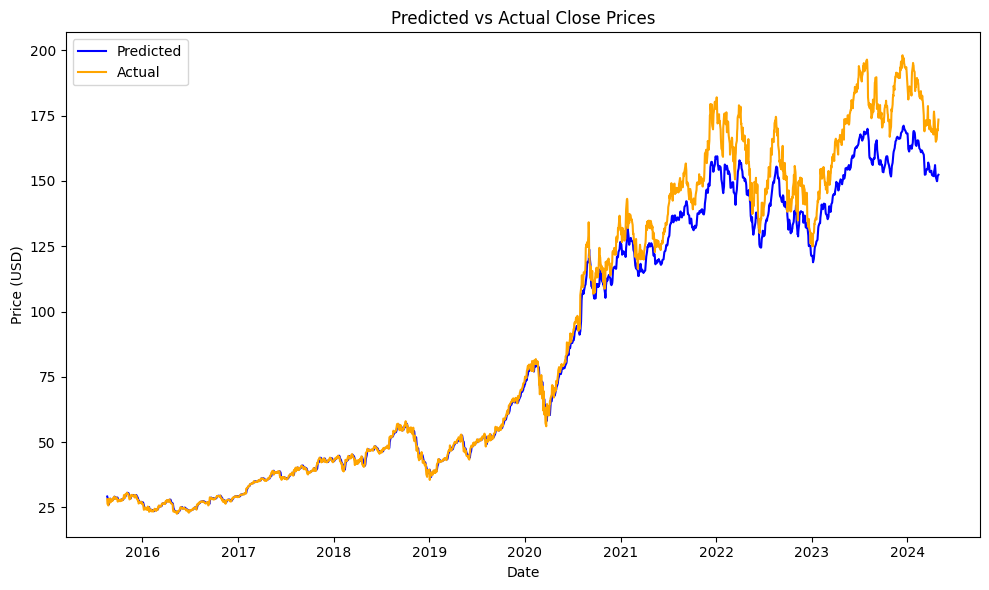

MSE: 98.44169588304159, RMSE: 9.921778866868662, MAE: 6.307630750508096, MAPE: 4.57813469176388, Direction Accuracy: 49.03934126258005%, R-squared: 0.970419085789425


In [28]:
# Predict and evaluate
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predicted vs actual close prices using test data
plt.figure(figsize=(10,6))
plt.plot(data['Date'][split + 3:], predictions, label='Predicted', color='blue')
plt.plot(data['Date'][split + 3:], y_test, label='Actual', color='orange')
plt.title('Predicted vs Actual Close Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
direction_accuracy = (np.sign(y_test[1:] - y_test[:-1]) == np.sign(predictions[1:] - predictions[:-1])).mean()
r_squared = r2_score(y_test, predictions)

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, Direction Accuracy: {direction_accuracy*100}%, R-squared: {r_squared}')